In [257]:
import pandas as pd
pd.set_option("display.max_rows", 500)
import numpy as np
import math
from append_df import cc1, cc2
import sys
sys.path.append("/home/lishiyu/Project/bin_tools")
from bins import binning, bins_simple_mean
from pvdict_utils import *
from exch_detail import append_feature_exch_detail
from tick_detail import append_tick_detail
from get_feature_data import get_feature_data
from timeseries_detail import *
from clickhouse_driver import Client
from pandas.api.types import infer_dtype
from sql import rsq
import re
import gc

import sys
sys.path.append("../")
from explore.backtest import ret_ts

sql = """select
TradingDay,
ExchTimeOffsetUs,
Session,
tick_open,
tick_close,
tick_high,
tick_low,
Volume_DiffLen1,
Turnover_DiffLen1S,
MX_exch_detail,
RT20,
RT40,
RT60,
RM1,
RM3,
RM5,
RM10,
RM15,
RM20,
RM30
from rb.detail
where TradingDay>='2022-12-01'
and TradingDay<='2023-03-18'
order by TradingDay, ExchTimeOffsetUs
"""

data = rsq(sql)
data = cc2(data, append_crossday_return)
data.r1({"tick_open": "open",
         "tick_close": "close",
         "tick_high": "high",
         "tick_low": "low",
         "Volume_DiffLen1": "volume",          
         })
Ry = data.cc("RT|RM").ncc("ORT|ORM").tolist()
data = cc2(data, append_techIdxBasic)
data = cc2(data, append_MAIdx)

erase_y = {
    "ORT20":20, 
    "ORT40":40, 
    "ORT60":60, 
    "ORM1":120, 
    "ORM3":360, 
    "ORM5":600, 
    "ORM10":1200, 
    "ORM15":1800, 
    "ORM20":2400, 
    "ORM30":3600, 
    "ORM40":4800, 
    "ORM50":6000, 
    "ORM60":7200, 
    
}

erase_x = {
    "TX_sma_10":10, 
    "TX_sma_30":30, 
    "TX_sma_60":60, 
    "TX_sma_120":120, 
    "TX_sma_180":180, 
    "TX_sma_240":240, 
    "TX_sma_360":360, 
    "TX_sma_480":480,
    "TX_sma_600": 600, 
    "TX_sma_720": 720, 
    "TX_sma_960": 960, 
    "TX_sma_1200": 1200, 
    "TX_sma_1800": 1800, 
    "TX_sma_2400": 2400, 
    "TX_sma_3600": 3600, 
    
    "TX_ema_10":60, 
    "TX_ema_30":60, 
    "TX_ema_60":120, 
    "TX_ema_120":240, 
    "TX_ema_180":360, 
    "TX_ema_240":480, 
    "TX_ema_360":720, 
    "TX_ema_480":960,
    "TX_ema_600": 600, 
    "TX_ema_720": 720, 
    "TX_ema_960": 960, 
    "TX_ema_1200": 1200, 
    "TX_ema_1800": 1800, 
    "TX_ema_2400": 2400, 
    "TX_ema_3600": 3600, 
}

xidx = data.cc("^TX")
yidx = data.cc("^ORM|^ORT")

for i in xidx:
    erase_period = erase_x.get(i, 60)
    data.loc[data["from_begin0"] <= erase_period / 2, i] = None

for i in yidx:
    erase_period = erase_y.get(i, 60)
    data.loc[data["to_end0"] <= erase_period / 2, i] = None


Error on localhost:9000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.
Error on socket shutdown: [Errno 107] Transport endpoint is not connected
/home/lishiyu/Project/data_process/sql.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.colinfo = pd.DataFrame(columns, columns=["name", "typesql"])
/home/lishiyu/Project/data_process/sql.py:165: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.mxcols = mxcols


In [ ]:
# 长周期
# 
# 默认指标
# TXB_HT_DCPERIOD
# TXB_ADX
# TXB_ADXR
# TXB_ATR
# TXB_NATR
# TXB_PLUS_DI
# TXB_PLUS_DM
# TXB_MINUS_DI
# TXB_MINUS_DM
# 
# 不稳定
# TXB_MFI
# 
# 均线
# TXMA_sma_1800
# TXMA_ema_1800
# TXMA_sma_2400
# TXMA_ema_2400
# TXMA_sma_3600
# TXMA_ema_3600

# data[xidx].isnull().mean().sort_values()
# TXB_MFI                     0.989496
# TXB_OBV                     0.989496
# TXB_AD                      0.989496
# TXB_ADOSC                   0.989496
# NA过多 忽略

In [258]:
import matplotlib.pyplot as plt

In [259]:
rt=ret_ts(data["ORM30"])

In [261]:
def check_idx(idx,up=True,quant=0.99,span=1800):
    if up:
        cond=data[idx]>data[idx].quantile(quant)
    else:
        cond=data[idx]<data[idx].quantile(quant)
    rt.test1(cond,span)
    print(pd.Series(rt.show_info()))
    plt.plot(rt.RCumsum)
    plt.show()    

TXB_HT_DCPERIOD
Mean              0.000893
Sum            2589.000000
RMean             0.489378
RSum           1267.000000
RStd             13.023979
WinRate           0.504056
WinRMean          9.960920
LoseRate          0.460409
LoseRMean        -9.842282
maxDrawdown    1209.000000
calmarRatio       1.047974
sharpRatio        0.037575
dtype: float64


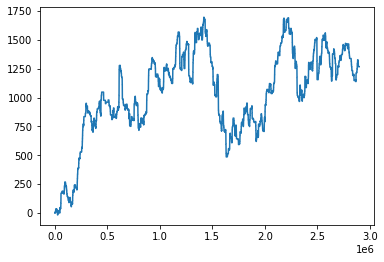

TXB_ADX
Mean              0.000892
Sum            2586.000000
RMean            -0.221578
RSum           -573.000000
RStd             13.533825
WinRate           0.480278
WinRMean         10.006441
LoseRate          0.481052
LoseRMean       -10.450965
maxDrawdown    2078.000000
calmarRatio      -0.275746
sharpRatio       -0.016372
dtype: float64


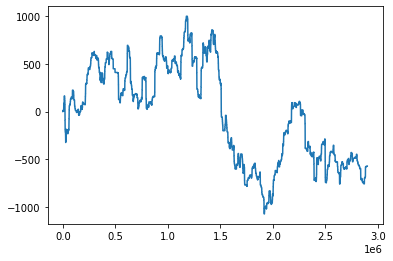

TXB_ADXR
Mean              0.000605
Sum            1755.000000
RMean             0.088319
RSum            155.000000
RStd             13.679240
WinRate           0.492308
WinRMean         10.188657
LoseRate          0.463818
LoseRMean       -10.624079
maxDrawdown    1708.000000
calmarRatio       0.090749
sharpRatio        0.006456
dtype: float64


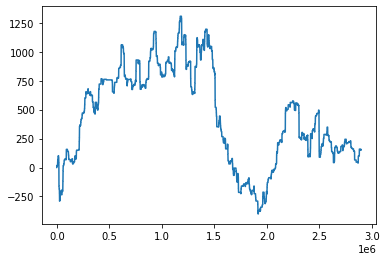

TXB_ATR
Mean              0.001076
Sum            3119.000000
RMean             0.856044
RSum           2670.000000
RStd             13.011077
WinRate           0.491183
WinRMean         10.461488
LoseRate          0.468099
LoseRMean        -9.148630
maxDrawdown    1484.000000
calmarRatio       1.799191
sharpRatio        0.065793
dtype: float64


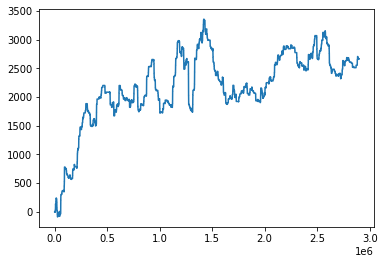

TXB_NATR
Mean              0.001077
Sum            3123.000000
RMean             0.683638
RSum           2135.000000
RStd             12.977453
WinRate           0.487672
WinRMean         10.314511
LoseRate          0.472302
LoseRMean        -9.202712
maxDrawdown    1626.000000
calmarRatio       1.313038
sharpRatio        0.052679
dtype: float64


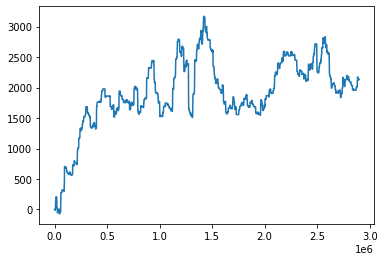

TXB_PLUS_DI
Mean              0.000650
Sum            1884.000000
RMean             1.501062
RSum           2828.000000
RStd             14.478196
WinRate           0.544055
WinRMean         11.410732
LoseRate          0.428344
LoseRMean       -10.988848
maxDrawdown    1056.000000
calmarRatio       2.678030
sharpRatio        0.103677
dtype: float64


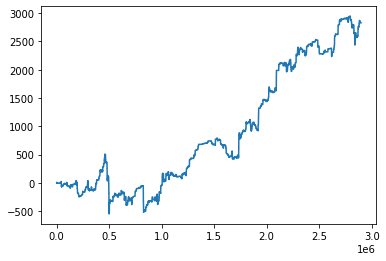

TXB_PLUS_DM
Mean              0.000695
Sum            2014.000000
RMean             1.429494
RSum           2879.000000
RStd             14.330315
WinRate           0.533764
WinRMean         11.441860
LoseRate          0.435948
LoseRMean       -10.730068
maxDrawdown    1028.000000
calmarRatio       2.800584
sharpRatio        0.099753
dtype: float64


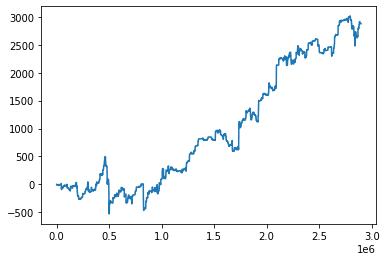

TXB_MINUS_DI
Mean              0.000686
Sum            1989.000000
RMean             1.073404
RSum           2135.000000
RStd             14.191655
WinRate           0.506787
WinRMean         11.245040
LoseRate          0.451483
LoseRMean       -10.244989
maxDrawdown     920.000000
calmarRatio       2.320652
sharpRatio        0.075636
dtype: float64


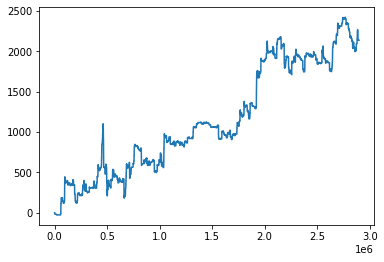

TXB_MINUS_DM
Mean              0.000727
Sum            2106.000000
RMean             0.986230
RSum           2077.000000
RStd             13.841289
WinRate           0.507123
WinRMean         10.897940
LoseRate          0.455840
LoseRMean        -9.960417
maxDrawdown     918.000000
calmarRatio       2.262527
sharpRatio        0.071253
dtype: float64


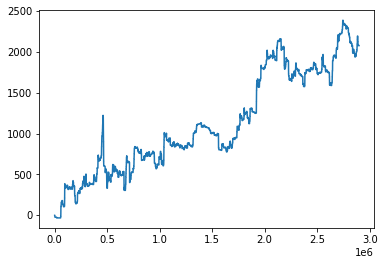

TXMA_sma_1800
Mean              0.000221
Sum             642.000000
RMean             1.688474
RSum           1084.000000
RStd             12.838958
WinRate           0.552960
WinRMean         10.845070
LoseRate          0.404984
LoseRMean       -10.638462
maxDrawdown     664.000000
calmarRatio       1.632530
sharpRatio        0.131512
dtype: float64


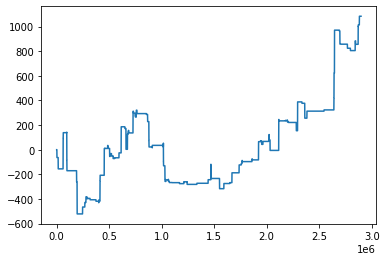

TXMA_ema_1800
Mean             0.000229
Sum            665.000000
RMean            1.446617
RSum           962.000000
RStd            12.599744
WinRate          0.545865
WinRMean        10.462810
LoseRate         0.404511
LoseRMean      -10.542751
maxDrawdown    708.000000
calmarRatio      1.358757
sharpRatio       0.114813
dtype: float64


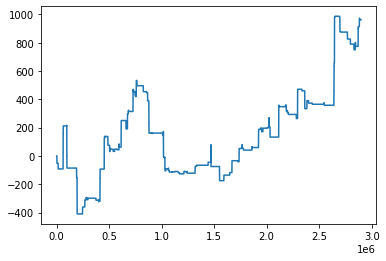

TXMA_sma_2400
Mean              0.000209
Sum             607.000000
RMean             2.222405
RSum           1349.000000
RStd             12.644477
WinRate           0.584843
WinRMean         10.729577
LoseRate          0.373970
LoseRMean       -10.837004
maxDrawdown     768.000000
calmarRatio       1.756510
sharpRatio        0.175761
dtype: float64


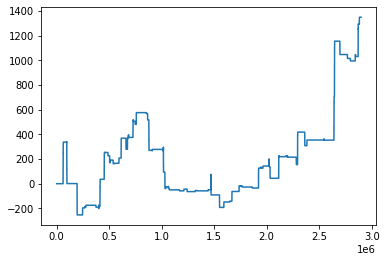

TXMA_ema_2400
Mean              0.000217
Sum             630.000000
RMean             1.949206
RSum           1228.000000
RStd             12.164112
WinRate           0.565079
WinRMean         10.463483
LoseRate          0.393651
LoseRMean       -10.068548
maxDrawdown     761.000000
calmarRatio       1.613666
sharpRatio        0.160242
dtype: float64


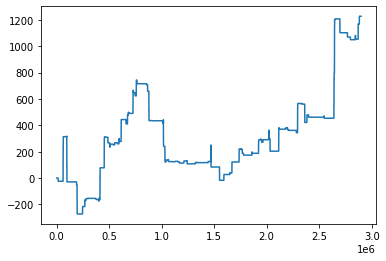

TXMA_sma_3600
Mean              0.000199
Sum             577.000000
RMean             1.925477
RSum           1111.000000
RStd             12.315429
WinRate           0.563258
WinRMean         10.686154
LoseRate          0.388215
LoseRMean       -10.544643
maxDrawdown     770.000000
calmarRatio       1.442857
sharpRatio        0.156347
dtype: float64


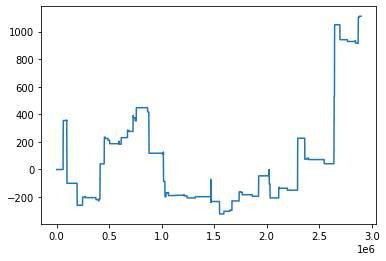

TXMA_ema_3600
Mean              0.000209
Sum             605.000000
RMean             1.770248
RSum           1071.000000
RStd             12.122380
WinRate           0.560331
WinRMean         10.306785
LoseRate          0.391736
LoseRMean       -10.223629
maxDrawdown     760.000000
calmarRatio       1.409211
sharpRatio        0.146031
dtype: float64


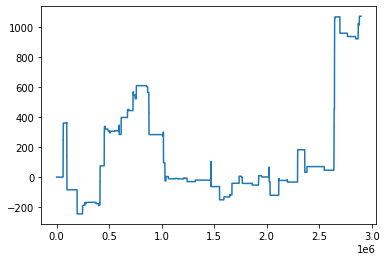

In [262]:
for i in ["TXB_HT_DCPERIOD",
"TXB_ADX",
"TXB_ADXR",
"TXB_ATR",
"TXB_NATR",
"TXB_PLUS_DI",
"TXB_PLUS_DM",
"TXB_MINUS_DI",
"TXB_MINUS_DM",
"TXMA_sma_1800",
"TXMA_ema_1800",
"TXMA_sma_2400",
"TXMA_ema_2400",
"TXMA_sma_3600",
"TXMA_ema_3600",
         ]:
    print(i)
    check_idx(i,quant=0.01,up=False,span=1200)

TXB_HT_DCPERIOD
Mean              0.001065
Sum            3087.000000
RMean             0.634921
RSum           1960.000000
RStd             15.325963
WinRate           0.512796
WinRMean         11.680985
LoseRate          0.455134
LoseRMean       -11.765836
maxDrawdown    2429.000000
calmarRatio       0.806916
sharpRatio        0.041428
dtype: float64


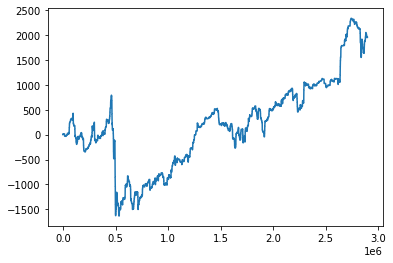

TXB_ADX
Mean              0.000575
Sum            1667.000000
RMean             0.800240
RSum           1334.000000
RStd             13.510444
WinRate           0.505699
WinRMean         10.418743
LoseRate          0.450510
LoseRMean        -9.918775
maxDrawdown     474.000000
calmarRatio       2.814346
sharpRatio        0.059231
dtype: float64


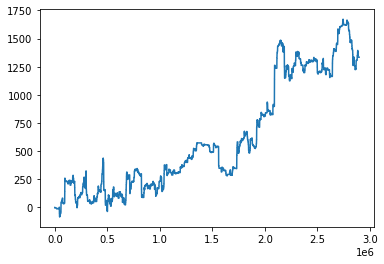

TXB_ADXR
Mean              0.000427
Sum            1237.000000
RMean             0.923201
RSum           1142.000000
RStd             13.447961
WinRate           0.507680
WinRMean         10.366242
LoseRate          0.446241
LoseRMean        -9.724638
maxDrawdown     355.000000
calmarRatio       3.216901
sharpRatio        0.068650
dtype: float64


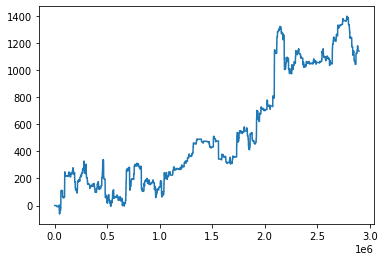

TXB_ATR
Mean              0.000564
Sum            1636.000000
RMean             2.084963
RSum           3411.000000
RStd             14.839966
WinRate           0.553178
WinRMean         12.243094
LoseRate          0.411369
LoseRMean       -11.395245
maxDrawdown     696.000000
calmarRatio       4.900862
sharpRatio        0.140497
dtype: float64


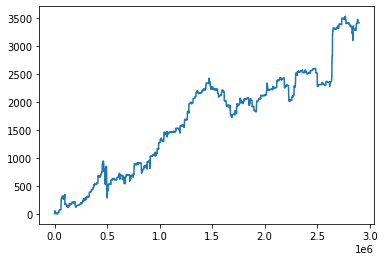

TXB_NATR
Mean              0.000540
Sum            1564.000000
RMean             2.017263
RSum           3155.000000
RStd             14.777959
WinRate           0.556905
WinRMean         12.097589
LoseRate          0.405371
LoseRMean       -11.643533
maxDrawdown     670.000000
calmarRatio       4.708955
sharpRatio        0.136505
dtype: float64


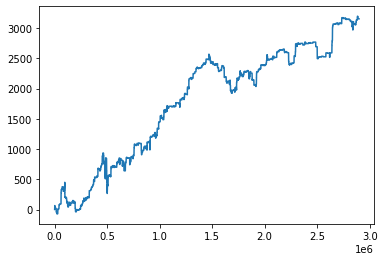

TXB_PLUS_DI
Mean              0.001611
Sum            4669.000000
RMean             0.090812
RSum            424.000000
RStd             13.148854
WinRate           0.468623
WinRMean         10.332724
LoseRate          0.489184
LoseRMean        -9.712785
maxDrawdown    2334.000000
calmarRatio       0.181662
sharpRatio        0.006906
dtype: float64


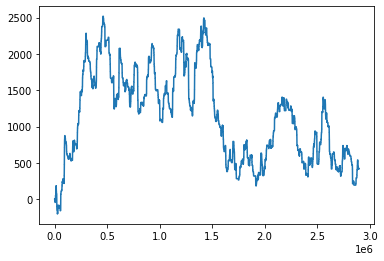

TXB_PLUS_DM
Mean              0.002040
Sum            5913.000000
RMean            -0.182987
RSum          -1082.000000
RStd             13.611552
WinRate           0.461525
WinRMean         10.630267
LoseRate          0.498901
LoseRMean       -10.200678
maxDrawdown    3269.000000
calmarRatio      -0.330988
sharpRatio       -0.013443
dtype: float64


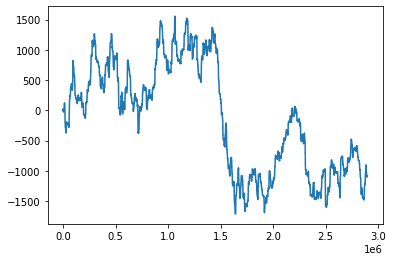

TXB_MINUS_DI
Mean              0.001569
Sum            4547.000000
RMean             0.508247
RSum           2311.000000
RStd             13.650792
WinRate           0.497471
WinRMean         10.524757
LoseRate          0.467561
LoseRMean       -10.111007
maxDrawdown    2317.000000
calmarRatio       0.997410
sharpRatio        0.037232
dtype: float64


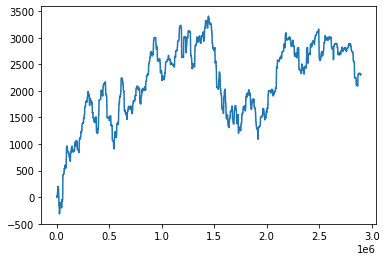

TXB_MINUS_DM
Mean              0.001870
Sum            5421.000000
RMean             0.455082
RSum           2467.000000
RStd             14.080857
WinRate           0.494743
WinRMean         10.925056
LoseRate          0.470393
LoseRMean       -10.523137
maxDrawdown    2881.000000
calmarRatio       0.856300
sharpRatio        0.032319
dtype: float64


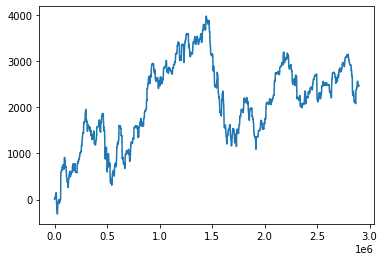

TXMA_sma_1800
Mean              0.000203
Sum             587.000000
RMean             0.984668
RSum            578.000000
RStd             17.081558
WinRate           0.567291
WinRMean         12.672673
LoseRate          0.407155
LoseRMean       -15.238494
maxDrawdown    1362.000000
calmarRatio       0.424376
sharpRatio        0.057645
dtype: float64


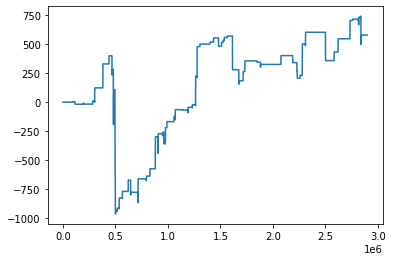

TXMA_ema_1800
Mean              0.000210
Sum             609.000000
RMean             0.837438
RSum            510.000000
RStd             17.317987
WinRate           0.564860
WinRMean         12.843023
LoseRate          0.408867
LoseRMean       -15.694779
maxDrawdown    1510.000000
calmarRatio       0.337748
sharpRatio        0.048357
dtype: float64


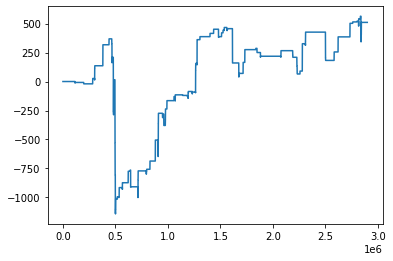

TXMA_sma_2400
Mean              0.000198
Sum             573.000000
RMean             1.593368
RSum            913.000000
RStd             16.858225
WinRate           0.600349
WinRMean         12.505814
LoseRate          0.385689
LoseRMean       -15.334842
maxDrawdown    1435.000000
calmarRatio       0.636237
sharpRatio        0.094516
dtype: float64


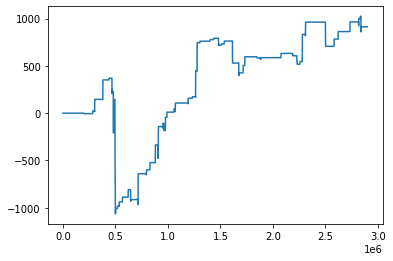

TXMA_ema_2400
Mean              0.000200
Sum             581.000000
RMean             1.514630
RSum            880.000000
RStd             17.345034
WinRate           0.578313
WinRMean         13.208333
LoseRate          0.394148
LoseRMean       -15.537118
maxDrawdown    1459.000000
calmarRatio       0.603153
sharpRatio        0.087324
dtype: float64


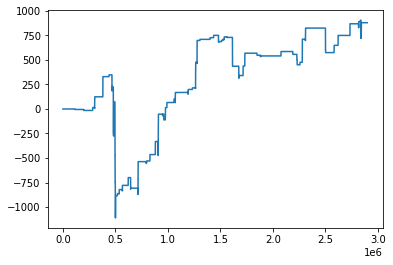

TXMA_sma_3600
Mean              0.000191
Sum             554.000000
RMean             2.088448
RSum           1157.000000
RStd             16.234976
WinRate           0.604693
WinRMean         12.659701
LoseRate          0.375451
LoseRMean       -14.826923
maxDrawdown    1415.000000
calmarRatio       0.817668
sharpRatio        0.128639
dtype: float64


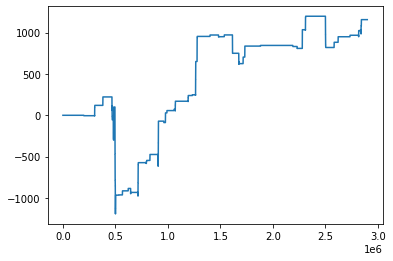

TXMA_ema_3600
Mean              0.000195
Sum             566.000000
RMean             2.346290
RSum           1328.000000
RStd             16.630611
WinRate           0.598940
WinRMean         13.342183
LoseRate          0.385159
LoseRMean       -14.655963
maxDrawdown    1319.000000
calmarRatio       1.006823
sharpRatio        0.141083
dtype: float64


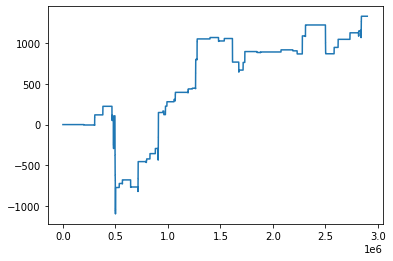

In [263]:
for i in ["TXB_HT_DCPERIOD",
"TXB_ADX",
"TXB_ADXR",
"TXB_ATR",
"TXB_NATR",
"TXB_PLUS_DI",
"TXB_PLUS_DM",
"TXB_MINUS_DI",
"TXB_MINUS_DM",
"TXMA_sma_1800",
"TXMA_ema_1800",
"TXMA_sma_2400",
"TXMA_ema_2400",
"TXMA_sma_3600",
"TXMA_ema_3600",
         ]:
    print(i)
    check_idx(i,quant=0.99,span=1200)

In [266]:
from sklearn.linear_model import Lasso,LassoCV

In [267]:
xidx=["TXB_HT_DCPERIOD", "TXB_ADX", "TXB_ADXR", 
      "TXB_ATR", 
      #"TXB_NATR", 
      "TXB_PLUS_DI", "TXB_PLUS_DM", "TXB_MINUS_DI", "TXB_MINUS_DM", 
      #"TXMA_sma_1800", 
      #"TXMA_ema_1800", 
      #"TXMA_sma_2400", 
      "TXMA_ema_2400", 
      #"TXMA_sma_3600", 
      #"TXMA_ema_3600"
     ]
yidx="ORM30"

lasso_data=data[xidx+[yidx]]

In [268]:
lasso_data=lasso_data[~lasso_data.isnull().any(axis=1)]

In [269]:
x=lasso_data[xidx]
x_mean=x.mean()
x_std=x.std()
x = (x - x.mean()) / x.std()
y = lasso_data[yidx]

In [270]:
num1 = int(x.shape[0] * 0.6)
num2 = int(x.shape[0] * 0.8)

x_train = x.iloc[:num1]
y_train = y.iloc[:num1]

x_valid = x.iloc[num1:num2]
y_valid = y.iloc[num1:num2]

x_test = x.iloc[num2:]
y_test = y.iloc[num2:]

In [271]:
from IPython.display import display

In [272]:
from sklearn.linear_model import Lasso,LassoCV
for i in ([0.001,0.005,0.01,0.02,0.03,0.05,0.1]):
    print(i)
    lasso_model=Lasso(i)
    lasso_model.fit(x_train, y_train)
    z_valid = pd.concat([pd.Series(lasso_model.predict(x_valid), index=x_valid.index), y_valid], axis=1)
    display(z_valid.b2(x=0, y=yidx, quant=20))

0.001


,bin_name,cnt,mean
0,"[-1.484, -0.169]",26371.0,0.462705
1,"(-0.169, -0.062]",26370.0,0.588168
2,"(-0.062, 0.013]",26370.0,0.626811
3,"(0.013, 0.074]",26370.0,0.641107
4,"(0.074, 0.129]",26370.0,0.903299
5,"(0.129, 0.181]",26371.0,0.917106
6,"(0.181, 0.231]",26370.0,0.829693
7,"(0.231, 0.281]",26370.0,0.795563
8,"(0.281, 0.332]",26370.0,0.801517
9,"(0.332, 0.385]",26370.0,1.031172


0.005


,bin_name,cnt,mean
0,"[-1.627, -0.156]",26371.0,0.433279
1,"(-0.156, -0.05]",26370.0,0.598369
2,"(-0.05, 0.025]",26370.0,0.606674
3,"(0.025, 0.087]",26370.0,0.774972
4,"(0.087, 0.142]",26370.0,0.856238
5,"(0.142, 0.193]",26371.0,0.823063
6,"(0.193, 0.243]",26370.0,0.970383
7,"(0.243, 0.293]",26370.0,0.777778
8,"(0.293, 0.344]",26370.0,0.822412
9,"(0.344, 0.396]",26370.0,0.908305


0.01


,bin_name,cnt,mean
0,"[-1.813, -0.147]",26371.0,0.441621
1,"(-0.147, -0.042]",26370.0,0.565036
2,"(-0.042, 0.034]",26370.0,0.745089
3,"(0.034, 0.097]",26370.0,0.750626
4,"(0.097, 0.153]",26370.0,0.808457
5,"(0.153, 0.206]",26371.0,0.888400
6,"(0.206, 0.257]",26370.0,0.809936
7,"(0.257, 0.308]",26370.0,0.896397
8,"(0.308, 0.36]",26370.0,0.809632
9,"(0.36, 0.412]",26370.0,0.915472


0.02


,bin_name,cnt,mean
0,"[-1.606, -0.128]",26371.0,0.470555
1,"(-0.128, -0.026]",26370.0,0.661661
2,"(-0.026, 0.049]",26370.0,0.717634
3,"(0.049, 0.11]",26370.0,0.722488
4,"(0.11, 0.166]",26370.0,0.784717
5,"(0.166, 0.218]",26371.0,0.869667
6,"(0.218, 0.268]",26370.0,0.816951
7,"(0.268, 0.318]",26370.0,0.823891
8,"(0.318, 0.368]",26370.0,0.774706
9,"(0.368, 0.418]",26370.0,0.907774


0.03


,bin_name,cnt,mean
0,"[-1.583, -0.102]",26371.0,0.461302
1,"(-0.102, -0.005]",26370.0,0.718620
2,"(-0.005, 0.065]",26370.0,0.633295
3,"(0.065, 0.124]",26370.0,0.828328
4,"(0.124, 0.176]",26370.0,0.741107
5,"(0.176, 0.225]",26371.0,0.823860
6,"(0.225, 0.273]",26370.0,0.843383
7,"(0.273, 0.32]",26370.0,0.829541
8,"(0.32, 0.368]",26370.0,0.793060
9,"(0.368, 0.416]",26370.0,0.873417


0.05


,bin_name,cnt,mean
0,"[-1.537, -0.054]",26371.0,0.460999
1,"(-0.054, 0.033]",26370.0,0.680622
2,"(0.033, 0.096]",26370.0,0.698749
3,"(0.096, 0.149]",26370.0,0.914448
4,"(0.149, 0.196]",26370.0,0.715169
5,"(0.196, 0.24]",26371.0,0.799325
6,"(0.24, 0.283]",26370.0,0.877626
7,"(0.283, 0.326]",26370.0,0.859841
8,"(0.326, 0.368]",26370.0,0.767160
9,"(0.368, 0.411]",26370.0,0.948350


0.1


,bin_name,cnt,mean
0,"[-1.541, 0.05]",26371.0,0.433355
1,"(0.05, 0.118]",26370.0,0.605650
2,"(0.118, 0.166]",26370.0,0.833447
3,"(0.166, 0.207]",26370.0,0.869700
4,"(0.207, 0.243]",26370.0,0.920516
5,"(0.243, 0.277]",26371.0,0.907967
6,"(0.277, 0.309]",26370.0,0.844937
7,"(0.309, 0.341]",26370.0,0.881229
8,"(0.341, 0.374]",26370.0,0.954342
9,"(0.374, 0.406]",26370.0,0.881039


In [277]:
lasso_model=Lasso(0.1)
lasso_model.fit(x_train, y_train)
z_train = pd.concat([pd.Series(lasso_model.predict(x_train), index=x_train.index), y_train], axis=1)
display(z_train.b2(x=0, y=yidx, quant=20))

z_valid = pd.concat([pd.Series(lasso_model.predict(x_valid), index=x_valid.index), y_valid], axis=1)
display(z_valid.b2(x=0, y=yidx, quant=20))

z_test = pd.concat([pd.Series(lasso_model.predict(x_test), index=x_test.index), y_test], axis=1)
display(z_test.b2(x=0, y=yidx, quant=20))

,bin_name,cnt,mean
0,"[-8.949, 0.021]",79111.0,-0.541581
1,"(0.021, 0.088]",79111.0,-0.102615
2,"(0.088, 0.135]",79110.0,-0.022816
3,"(0.135, 0.174]",79111.0,0.017962
4,"(0.174, 0.209]",79110.0,-0.002743
5,"(0.209, 0.242]",79110.0,0.146644
6,"(0.242, 0.273]",79111.0,0.242798
7,"(0.273, 0.304]",79110.0,0.247314
8,"(0.304, 0.334]",79111.0,0.269925
9,"(0.334, 0.365]",79110.0,0.381064


,bin_name,cnt,mean
0,"[-1.541, 0.05]",26371.0,0.433355
1,"(0.05, 0.118]",26370.0,0.605650
2,"(0.118, 0.166]",26370.0,0.833447
3,"(0.166, 0.207]",26370.0,0.869700
4,"(0.207, 0.243]",26370.0,0.920516
5,"(0.243, 0.277]",26371.0,0.907967
6,"(0.277, 0.309]",26370.0,0.844937
7,"(0.309, 0.341]",26370.0,0.881229
8,"(0.341, 0.374]",26370.0,0.954342
9,"(0.374, 0.406]",26370.0,0.881039


,bin_name,cnt,mean
0,"[-2.494, 0.043]",26371.0,-0.366615
1,"(0.043, 0.108]",26370.0,-0.209025
2,"(0.108, 0.156]",26370.0,0.047744
3,"(0.156, 0.195]",26370.0,0.287031
4,"(0.195, 0.231]",26370.0,0.384528
5,"(0.231, 0.264]",26371.0,0.492624
6,"(0.264, 0.296]",26370.0,0.590482
7,"(0.296, 0.328]",26370.0,0.749336
8,"(0.328, 0.359]",26370.0,0.866439
9,"(0.359, 0.391]",26370.0,0.954418


In [278]:
score=lasso_model.predict(x)

In [280]:
pd.Series(lasso_model.coef_,index=xidx)

TXB_HT_DCPERIOD   -0.000000
TXB_ADX            0.000000
TXB_ADXR           0.129292
TXB_ATR            0.000000
TXB_PLUS_DI       -0.000000
TXB_PLUS_DM       -0.152727
TXB_MINUS_DI      -0.040220
TXB_MINUS_DM      -0.017820
TXMA_ema_2400      0.098000
dtype: float64

In [338]:
rt=ret_ts(data["ORM30"])

Mean               0.010371
Sum            30062.000000
RMean              0.089448
RSum            2689.000000
RStd              13.893152
WinRate            0.473821
WinRMean          10.864013
LoseRate           0.487692
LoseRMean        -10.371598
maxDrawdown    13385.000000
calmarRatio        0.200897
sharpRatio         0.006438
dtype: float64

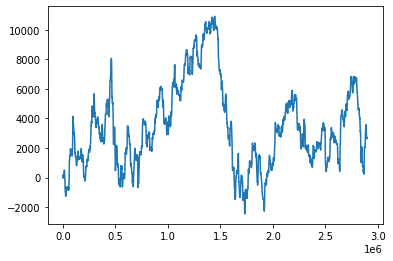

In [341]:
cond=(data["TXB_TEMA"]<data["TXB_TEMA"].quantile(0.05))
rt.test1(cond,1200)
plt.plot(rt.RCumsum)
display(pd.Series(rt.show_info()))
plt.show()   

Mean               0.002711
Sum             7859.000000
RMean              1.279425
RSum           10055.000000
RStd              14.428744
WinRate            0.524367
WinRMean          11.459840
LoseRate           0.438733
LoseRMean        -10.780452
maxDrawdown     3871.000000
calmarRatio        2.597520
sharpRatio         0.088672
dtype: float64

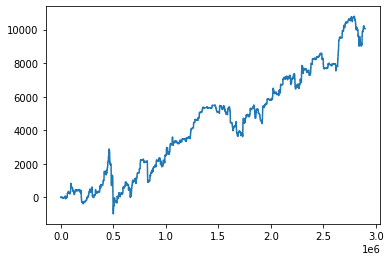

In [350]:
cond=(data["TXB_PLUS_DI"]<data["TXB_PLUS_DI"].quantile(0.05))
rt.test1(cond,1800)
plt.plot(rt.RCumsum)
display(pd.Series(rt.show_info()))
plt.show()   

Mean               0.003993
Sum            11574.000000
RMean              0.023242
RSum             269.000000
RStd              13.389894
WinRate            0.469501
WinRMean          10.359220
LoseRate           0.486867
LoseRMean         -9.941970
maxDrawdown     5576.000000
calmarRatio        0.048242
sharpRatio         0.001736
dtype: float64

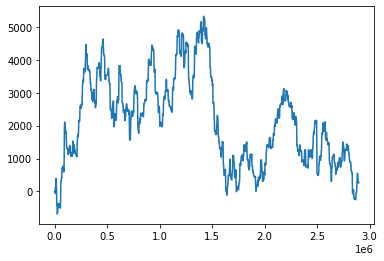

In [348]:
cond=(data["TXB_PLUS_DI"]>data["TXB_PLUS_DI"].quantile(0.95))
rt.test1(cond,1200)
plt.plot(rt.RCumsum)
display(pd.Series(rt.show_info()))
plt.show()   

Mean               0.013360
Sum            38726.000000
RMean              0.857305
RSum           33200.000000
RStd              13.879112
WinRate            0.504080
WinRMean          10.961375
LoseRate           0.459381
LoseRMean        -10.161720
maxDrawdown    13415.000000
calmarRatio        2.474842
sharpRatio         0.061769
dtype: float64

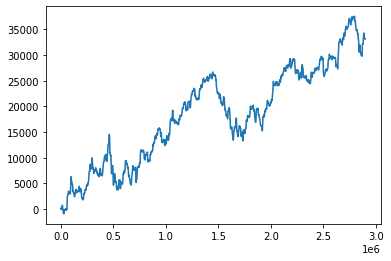

In [357]:
cond=(data["TXB_CDLGRAVESTONEDOJI"]>0)
rt.test1(cond,1800)
plt.plot(rt.RCumsum)
display(pd.Series(rt.show_info()))
plt.show()   

In [353]:
data["TXB_CDLGRAVESTONEDOJI"].value_counts()

0.0      2363288
100.0     531162
Name: TXB_CDLGRAVESTONEDOJI, dtype: int64